In [37]:
#Code must be executed in PUI2016_Python3 Kernel

import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sn
import datetime as dt
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
# Map visualization code obtained from Juan Sokoloff, fellow classmate.
urllib.request.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")
import choroplethNYC as cp

In [39]:
# Import Census Blocks shapefile as a geodataframe
# Obtained from CUNY Urban Research center
blocks = gp.GeoDataFrame.from_file("Data/Blocks_shape/blocks_clip.shp")
blocks.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'BLOCKID10', 'STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'CBSA',
       'P0020001', 'P0020002', 'P0020003', 'P0020004', 'P0020005', 'P0020006',
       'P0020007', 'P0020008', 'P0020009', 'P0020010', 'P0020011', 'P2K20001',
       'P2K20002', 'P2K20003', 'P2K20004', 'P2K20005', 'P2K20006', 'P2K20007',
       'P2K20008', 'P2K20009', 'P2K20010', 'P2K20011', 'WHITE10', 'LATINO10',
       'BLACK10', 'ASIAN10', 'OTHERS10', 'PLURAL10', 'PLURALN10', 'TIE10',
       'WHITE00', 'LATINO00', 'BLACK00', 'ASIAN00', 'OTHERS00', 'PLURAL00',
       'PLURALN00', 'TIE00', 'CHGT0010', 'CHGW0010', 'CHGB0010', 'CHGA0010',
       'CHGH0010', 'CHGO0010', 'geometry'],
      dtype='object')

In [40]:
# Load the full datasets used in the logistic regression model
blocks_data = pd.read_csv("Data/Blocks_full_dataset.csv", usecols=range(1,35), dtype= {'BLOCKID': str} )
blocks_data.shape

(29204, 34)

In [41]:
#See all the columns
blocks_data.columns

Index(['BLOCKID', 'Inc01_2002', 'Inc02_2002', 'Inc03_2002', 'Ed01_2002',
       'Ed02_2002', 'Ed03_2002', 'Ed04_2002', 'Inc01_2010', 'Inc02_2010',
       'Inc03_2010', 'Ed01_2010', 'Ed02_2010', 'Ed03_2010', 'Ed04_2010',
       'pct_ch_hInc', 'pct_ch_hEduc', 'pct_ch_white', 'a_weight', 'bid_id',
       'BID_dummy', 'BoroName_Bronx', 'BoroName_Brooklyn',
       'BoroName_Manhattan', 'BoroName_Queens', 'shWhite00', 'shBlack00',
       'shBlack00.1', 'shAsian00', 'changesdummy', 'dist_sub_m', 'dist_sPark',
       'dist_lPark', 'PR_DWELLING_UNIT'],
      dtype='object')

In [42]:
blocks_data.head()

,BLOCKID,Inc01_2002,Inc02_2002,Inc03_2002,Ed01_2002,Ed02_2002,Ed03_2002,Ed04_2002,Inc01_2010,Inc02_2010,...,BoroName_Queens,shWhite00,shBlack00,shBlack00.1,shAsian00,changesdummy,dist_sub_m,dist_sPark,dist_lPark,PR_DWELLING_UNIT
0,360050001001000,32,30,15,0,0,0,0,35,48,...,0.0,8.521221,60.605009,60.605009,0.260854,0,2990.620117,2112.219971,1333.260010,0
1,360050001001013,31,20,6,0,0,0,0,14,22,...,0.0,8.487242,60.517723,60.517723,0.184505,0,2802.429932,1970.089966,1057.729981,0
2,360050002001000,15,48,15,0,0,0,0,24,55,...,0.0,9.885932,26.235741,26.235741,3.041825,0,2024.540039,443.230011,297.609009,0
3,360050002001001,19,31,19,0,0,0,0,11,28,...,0.0,7.853403,27.225131,27.225131,0.000000,0,2014.689941,477.950989,278.540008,0
4,360050002001002,26,43,16,0,0,0,0,14,50,...,0.0,3.859649,24.561404,24.561404,0.000000,0,2007.910034,522.379028,240.309998,0


In [43]:
blocks_data['pct_ch_white'].head()

0   -2.151056
1    0.955168
2   -8.161794
3   -5.097498
4   -1.228070
Name: pct_ch_white, dtype: float64

In [44]:
blocks_data['pct_ch_white'] = blocks_data['pct_ch_white']

In [45]:
# merge the shaoefile with our clean dataset
blocks_full = pd.merge(blocks, blocks_data,  left_on = 'BLOCKID10', 
                                                    right_on = 'BLOCKID', how = 'left')


### Map 1: Percentage Change in White Population

In [111]:
blocks_full['pct_ch_white'].head()

0          NaN
1   -17.525986
2    -1.340483
3   -12.498729
4          NaN
Name: pct_ch_white, dtype: float64

In [112]:
blocks_full_white= blocks_full.dropna(subset=['pct_ch_white'])
blocks_full_white['pct_ch_white'].head()

1   -17.525986
2    -1.340483
3   -12.498729
6    -5.535527
7    -3.571429
Name: pct_ch_white, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


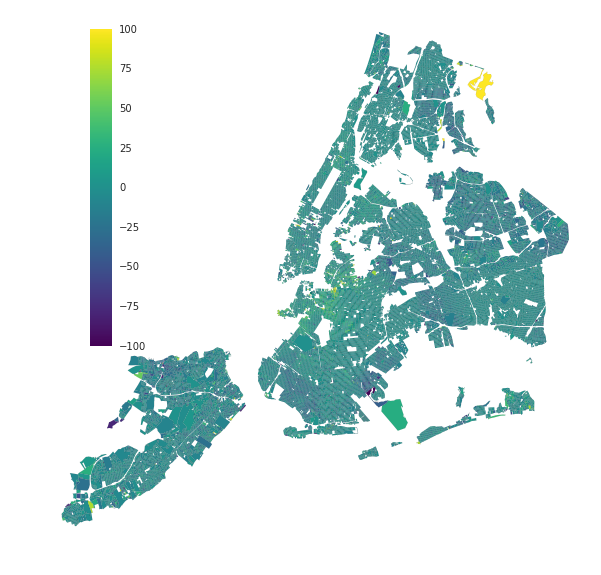

In [113]:
cp.choroplethNYC(blocks_full_white, column="pct_ch_white", color="k",cmap="viridis", edgecolor="k", lw=0.05);


* We can clearly identify areas with faster change in white population, in yellow.
* Northern Brooklyn concentrates most of the yellows.
* Neighborhoods as Williamsburg, Greenpoint, Crown Heights, Chelsea, Harlem and Long Island City.

### Map 2: Percentage Change in Highly Educated Workers


In [23]:
blocks_full['pct_ch_hEduc'].head()

0       NaN
1     480.0
2     890.0
3    2160.0
4       NaN
Name: pct_ch_hEduc, dtype: float64

In [109]:
blocks_full_hEd= blocks_full.dropna(subset=['pct_ch_hEduc'])
blocks_full_hEd['pct_ch_hEduc'].head()

1     480.0
2     890.0
3    2160.0
6     120.0
7      30.0
Name: pct_ch_hEduc, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


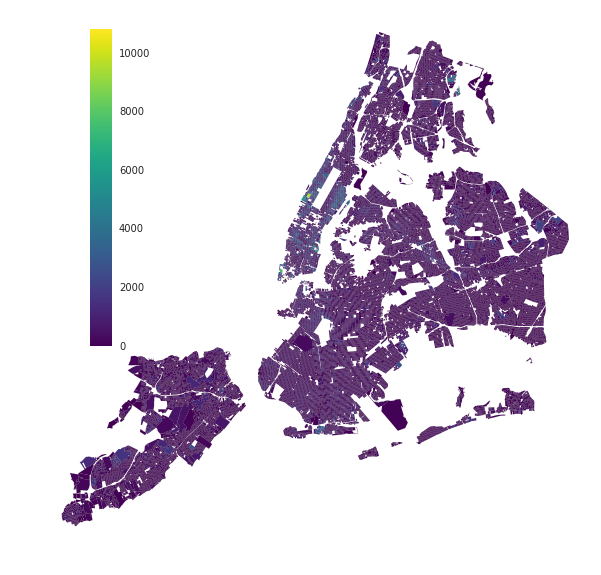

In [110]:
cp.choroplethNYC(blocks_full_hEd, column="pct_ch_hEduc", color="k",cmap="viridis", edgecolor="k", lw=0.05);

### Map 3: Percentage Change in High Income Workers

In [35]:
blocks_full['pct_ch_hInc'].head()

0         NaN
1    1.178248
2    0.594766
3    1.236589
4         NaN
Name: pct_ch_hInc, dtype: float64

In [107]:
blocks_full_hInc= blocks_full.dropna(subset=['pct_ch_hInc'])
blocks_full_hInc['pct_ch_hInc'].head()

1    1.178248
2    0.594766
3    1.236589
6    0.621118
7    1.290323
Name: pct_ch_hInc, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


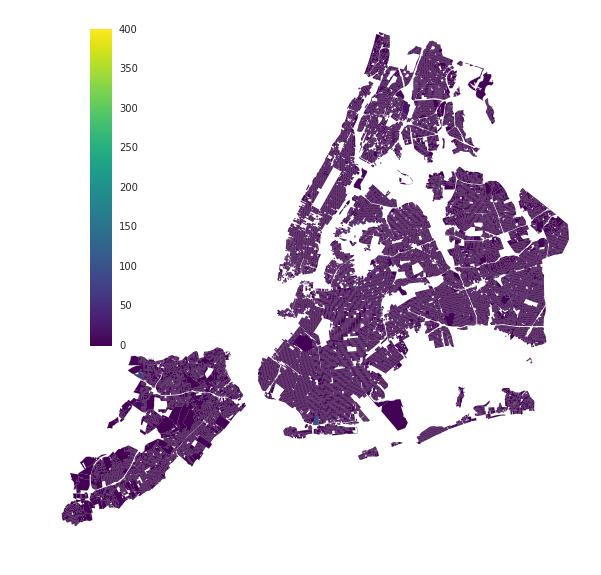

In [108]:
cp.choroplethNYC(blocks_full_hInc, column="pct_ch_hInc", color="k",cmap="viridis", edgecolor="k", lw=0.05);

### Map 4: Number of New Units per Block
Plot only Blocks that have had new units authorized since 2012.

In [91]:
blocks_full['PR_DWELLING_UNIT'][blocks_full['PR_DWELLING_UNIT']==0] = np.nan

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [92]:
blocks_full_buildings= blocks_full.dropna(subset=['PR_DWELLING_UNIT'])

In [104]:
blocks_full_buildings['PR_DWELLING_UNIT'].describe()

count    10046.000000
mean       258.697691
std       1538.275404
min          1.000000
25%          2.000000
50%          4.000000
75%         20.000000
max      48898.000000
Name: PR_DWELLING_UNIT, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


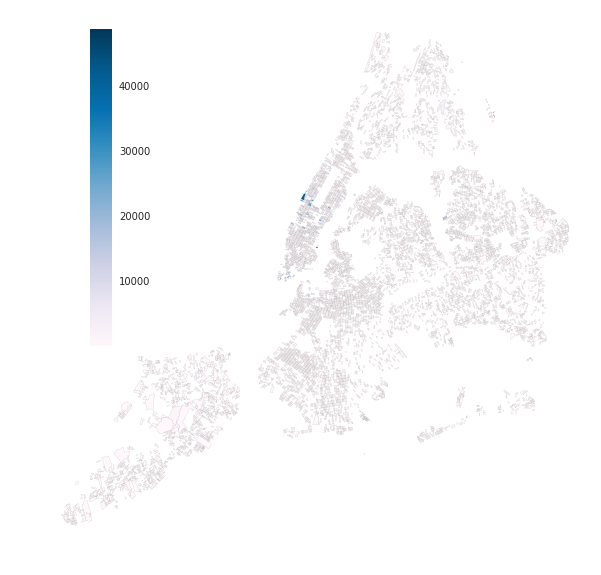

In [105]:
cp.choroplethNYC(blocks_full_buildings, column="PR_DWELLING_UNIT", cmap="PuBu",  color="k", edgecolor="k", lw=0.05);